##preprocessing

In [ ]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=06c0d02c916ad86a496370ee86618e4e51166bc045c8ae9034a9c5a9ce525172
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import missingno as msno
import keras
import pandas_ta as ta

In [ ]:
ibm_df=pd.read_csv('/content/IBM_weekly.csv', sep=',', header=0)
ibm_df['Date'] = pd.to_datetime(ibm_df.Date)

ibm_df_subset=ibm_df[ibm_df['Close']<ibm_df['Low']]

ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('2021-11-04'),['Open', 'High', 'Low']]=ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('2021-11-04'),['Open', 'High', 'Low']]/1.046

# adjust for the 1999-05-27 split, plus the Open and High at 1999-05-30, which are an anomaly in the dataset
ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('1999-05-27'),['Open', 'High', 'Low']]=ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('1999-05-27'),['Open', 'High', 'Low']]/2
ibm_df_subset.loc[ibm_df_subset['Date']==pd.to_datetime('1999-05-30'),['Open', 'High']]=ibm_df_subset.loc[ibm_df_subset['Date']==pd.to_datetime('1999-05-30'),['Open', 'High']]/2

# adjust for the 1997-05-28 split, plus the Open and High at 1997-06-01, which are an anomaly in the dataset
ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('1997-05-28'),['Open', 'High', 'Low']]=ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('1997-05-28'),['Open', 'High', 'Low']]/2
ibm_df_subset.loc[ibm_df_subset['Date']==pd.to_datetime('1997-06-01'),['Open', 'High']]=ibm_df_subset.loc[ibm_df_subset['Date']==pd.to_datetime('1997-06-01'),['Open', 'High']]/2

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler
scaler = StandardScaler()
scaler2 = MinMaxScaler()

#standardization of the prices
ibm_df[['Close', 'Open', 'Low', 'High']] = scaler.fit_transform(ibm_df[['Close', 'Open', 'Low', 'High']])
ibm_df.loc[ibm_df['Volume']>0, ['Volume']] = scaler2.fit_transform(ibm_df.loc[ibm_df['Volume']>0, ['Volume']])

In [ ]:
#hurst coefficient of the time series
def hurst(ts):

    n = len(ts)
    max_window = int(n / 2)
    window_sizes = range(10, max_window)
    R_S = np.zeros(len(window_sizes))

    for i, window_size in enumerate(window_sizes):
        window_ranges = np.arange(0, n, window_size)
        R, S = 0, 0
        for j in window_ranges:
            if j + window_size < n:
                # Calculate the range and standard deviation
                window = ts[j:j+window_size]
                R += np.max(window) - np.min(window)
                S += np.std(window)

        # Calculate the rescaled range
        R_S[i] = R / S

    # Fit a linear line to log-log plot
    fit = np.polyfit(np.log(window_sizes), np.log(R_S), 1)

    # Hurst exponent is the slope of the line
    hurst_exponent = fit[0]

    return hurst_exponent


ts = ibm_df['Close']
print("Hurst Exponent for Close:", hurst(ts))

ibm_df['log return'] = np.log(ibm_df['Close'].shift(-1)/ibm_df['Close'])
ts1 = ibm_df['log return']
print("Hurst Exponent for Log return:", hurst(ts1))

ibm_df['return'] = ibm_df['Close'].shift(-1)/ibm_df['Close']
ts2 = ibm_df['return']
print("Hurst Exponent for return:", hurst(ts2))


Hurst Exponent for Close: -0.012834026646051653


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Hurst Exponent for Log return: 0.41846554526718005
Hurst Exponent for return: 0.4806478175681395


## PRIMA ARCHITETTURA

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],1))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model

In [ ]:
ibm_df.loc[0:5,'Close'] #cambio indicizzazione su python

0   -1.845263
1   -1.834125
2   -1.829844
3   -1.840550
4   -1.838408
5   -1.845691
Name: Close, dtype: float64

In [ ]:
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:splitlimit,:]
ibm_df_test_set = ibm_df.loc[splitlimit:,:]

X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(5, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(ibm_df.loc[x-5:x-1,'Close'])
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


X_test=[]
y_test =[]

for x in range(df_days, ibm_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(ibm_df.loc[x-5:x-1,'Close'])
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [ ]:
#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 5, 50)             0         
                                                                 
 dense (Dense)               (None, 5, 1)              51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/10
42/42 [==============================] - 2s 36ms/step - loss: 0.9445 - val_loss: 1.3462
Epoch 2/10
42/42 [==============================] - 1s 24ms/step - loss: 0.9436 - val_loss: 1.3282
Epoch 3/10
42/42 [==============================] - 1s 18ms/step - loss: 0.9439 - val_loss: 1.3697
Epoch 4/10
42/42 [==============================] - 1s 18ms/step - loss: 0.9439 - val_loss: 1.3853
Epoch 5/10
42/42 [==============================] - 1s 23ms/step - loss: 0.9428 - val_loss: 1.3086
Epoch 6/10
42/42 [==============================] - 1s 20ms/step - loss: 0.9431 - val_loss: 1.3541
Epoch 7/10
42/42 [==============================] - 1s 24ms/step - loss: 0.9438 - val_loss: 1.3786
Epoch 8/10
42/42 [==============================] - 1s 12ms/step - loss: 0.9434 - val_loss: 1.3591
Epoch 9/10
42/42 [==============================] - 0s 9ms/step - loss: 0.9442 - val_loss: 1.3746
Epoch 10/10
10/10 [==============================] - 0s 3ms/step


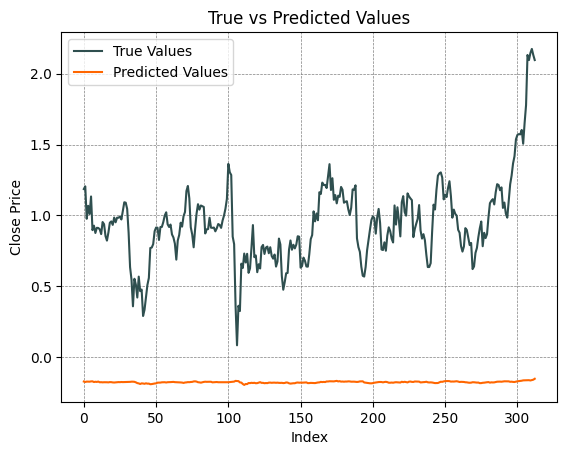

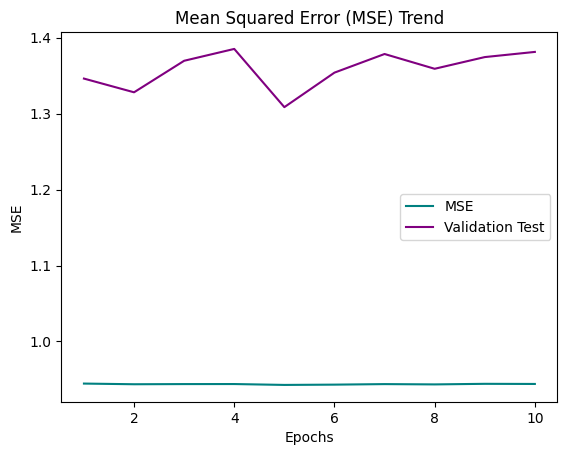

AttributeError: 'History' object has no attribute 'forecast'

In [ ]:
#training
history = model.fit(X_train, y_train,epochs=10, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.style.use('default')
plt.plot(y_test, label='True Values',color='#2F4F4F')
plt.plot(y_pred[:,0],  label='Predicted Values',color='#FF6600')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.savefig('ibm LSTM.png')
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE',color='#008080')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test',color='#800080')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()


#forecast
fc = results.forecast(314, alpha=0.05)
ibm_test['forecast'] = fc
plt.figure(figsize=(12,5), dpi=100)
plt.plot(ibm_train['Log Close'], color='green',label='training')
plt.plot(ibm_test['Log Close'], color='blue', label='Actual Log Close Price')
plt.plot(ibm_test['forecast'], color='orange', label='Predicted Close Price')
plt.title('IBM Close Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Epoch 1/50
42/42 [==============================] - 0s 11ms/step - loss: 0.9440 - val_loss: 1.3473
Epoch 2/50
42/42 [==============================] - 0s 10ms/step - loss: 0.9445 - val_loss: 1.3630
Epoch 3/50
42/42 [==============================] - 0s 11ms/step - loss: 0.9438 - val_loss: 1.3550
Epoch 4/50
42/42 [==============================] - 0s 10ms/step - loss: 0.9444 - val_loss: 1.3558
Epoch 5/50
42/42 [==============================] - 0s 10ms/step - loss: 0.9444 - val_loss: 1.3687
Epoch 6/50
42/42 [==============================] - 1s 15ms/step - loss: 0.9435 - val_loss: 1.3435
Epoch 7/50
42/42 [==============================] - 1s 19ms/step - loss: 0.9428 - val_loss: 1.3680
Epoch 8/50
42/42 [==============================] - 0s 11ms/step - loss: 0.9444 - val_loss: 1.3644
Epoch 9/50
42/42 [==============================] - 0s 10ms/step - loss: 0.9438 - val_loss: 1.3884
Epoch 10/50
42/42 [==============================] - 0s 10ms/step - loss: 0.9435 - val_loss: 1.3916
Epoch 11/

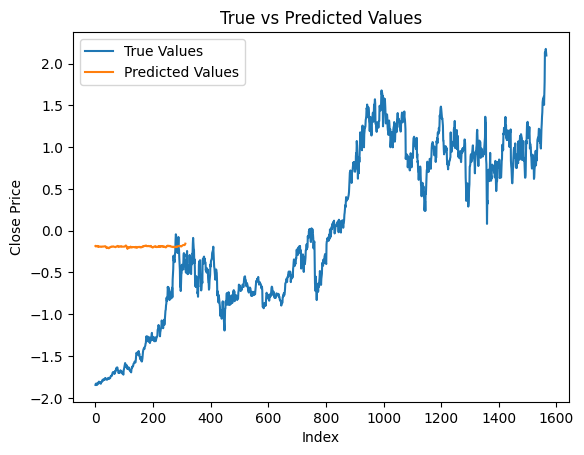

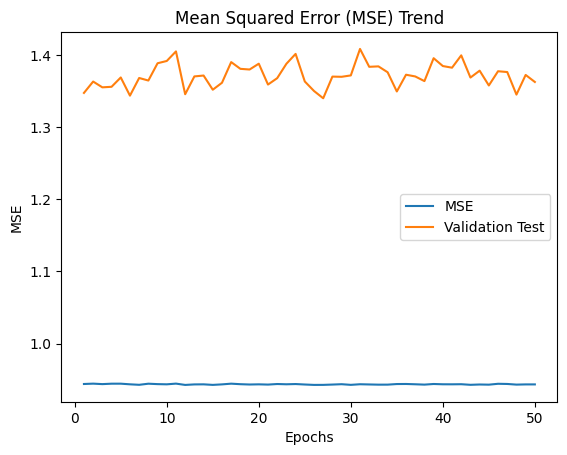

In [ ]:
#un'altra prova, aumentando il numero di epoche ma mantenendo lo stesso modello
#training
history = model.fit(X_train, y_train,epochs=50, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(ibm_df['Close'], label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
#stesso modello, aumentando la finestra temporale a 10 settimane (50 epoche)
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:splitlimit,:]
ibm_df_test_set = ibm_df.loc[splitlimit:,:]

X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(10, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(ibm_df.loc[x-10:x-1,'Close'])
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


X_test=[]
y_test =[]

for x in range(df_days, ibm_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(ibm_df.loc[x-10:x-1,'Close'])
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=50, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(ibm_df['Close'], label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

:## SECONDA ARCHITETTURA: inserisco anche gli indicatori in X_train input. 10 epoche, finestra di 5 settimane

In [ ]:
def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


ibm_df['RSI']=ta.rsi(ibm_df.Close, length=10)
ibm_df['EMAF']=ta.ema(ibm_df.Close, length=20)
ibm_df['EMAM']=ta.ema(ibm_df.Close, length=100)
ibm_df['EMAS']=ta.ema(ibm_df.Close, length=150)

ibm_df.dropna(inplace=True)
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:ibm_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(ibm_df.index[0]+5, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(ibm_df.loc[x-5:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(ibm_df.index[0]+df_days, ibm_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(ibm_df.loc[x-5:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=10, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(ibm_df['Close'], label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()


NameError: name 'ta' is not defined

##TERZA ARCHITETTURA: performance migliore di 4

In [ ]:
#nuovo modello: inserisco anche gli indicatori in X_train input. 30 epoche, finestra di 10 settimane

def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


ibm_df['RSI']=ta.rsi(ibm_df.Close, length=10)
ibm_df['EMAF']=ta.ema(ibm_df.Close, length=20)
ibm_df['EMAM']=ta.ema(ibm_df.Close, length=100)
ibm_df['EMAS']=ta.ema(ibm_df.Close, length=150)

ibm_df.dropna(inplace=True)
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:ibm_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(ibm_df.index[0]+10, df_days): #prendo intanto una finestra di 10 settimane
  X_train.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(ibm_df.index[0]+df_days, ibm_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=30, batch_size=10,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## QUARTA ARCHITETTURA: con indicatori, 15 epoche, e più layers.

In [ ]:
def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


ibm_df['RSI']=ta.rsi(ibm_df.Close, length=10)
ibm_df['EMAF']=ta.ema(ibm_df.Close, length=20)
ibm_df['EMAM']=ta.ema(ibm_df.Close, length=100)
ibm_df['EMAS']=ta.ema(ibm_df.Close, length=150)

ibm_df.dropna(inplace=True)
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:ibm_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(ibm_df.index[0]+10, df_days): #prendo intanto una finestra di 10 settimane
  X_train.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(ibm_df.index[0]+df_days, ibm_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')


#training
history = model.fit(X_train, y_train,epochs=15, batch_size=10,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## QUINTA ARCHITETTURA: ritorno verso la quarta, e riduco le units

In [ ]:
X_test

In [ ]:
def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=10,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=10,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


ibm_df['RSI']=ta.rsi(ibm_df.Close, length=10)
ibm_df['EMAF']=ta.ema(ibm_df.Close, length=20)
ibm_df['EMAM']=ta.ema(ibm_df.Close, length=100)
ibm_df['EMAS']=ta.ema(ibm_df.Close, length=150)

ibm_df.dropna(inplace=True)
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:ibm_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(ibm_df.index[0]+10, df_days): #prendo intanto una finestra di 10 settimane
  X_train.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(ibm_df.index[0]+df_days, ibm_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=30, batch_size=10,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## ARCHITETTURA CON LOG RETURN

In [ ]:
ibm_df['log return'] = np.log(ibm_df['Close'].shift(-1)/ibm_df['Close'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense


def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


ibm_df['RSI']=ta.rsi(ibm_df.Close, length=10)
ibm_df['EMAF']=ta.ema(ibm_df.Close, length=20)
ibm_df['EMAM']=ta.ema(ibm_df.Close, length=100)
ibm_df['EMAS']=ta.ema(ibm_df.Close, length=150)
ibm_df['log return'] = np.log(ibm_df['Close'].shift(-1)/ibm_df['Close'])

ibm_df.dropna(inplace=True)
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:ibm_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(ibm_df_train_set.index[0]+5,ibm_df_train_set.index[0]+ibm_df_train_set.shape[0]): #prendo intanto una finestra di 5 settimane
  X_train.append(ibm_df.loc[x-5:x-1,['log return','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(ibm_df.loc[x,'log return'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(df_days, ibm_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(ibm_df.loc[x-10:x-1,['log return','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(ibm_df.loc[x,'log return'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=30, batch_size=10,validation_data=(X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('log return close')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyError: 742

## mistero overfit

In [ ]:
ibm_df['RSI']=ta.rsi(ibm_df.Close, length=10)
ibm_df['EMAF']=ta.ema(ibm_df.Close, length=20)
ibm_df['EMAM']=ta.ema(ibm_df.Close, length=100)
ibm_df['EMAS']=ta.ema(ibm_df.Close, length=150)

ibm_df_set = ibm_df.loc[:, ['Date','Volume','Close','RSI', 'EMAF', 'EMAM','EMAS']].dropna()

splitlimit = int(len(ibm_df_set) * 0.8)
ibm_df_train_set = ibm_df_set.loc[:splitlimit,:] ####iloc
ibm_df_test_set = ibm_df_set.loc[splitlimit:,:]
#ibm_df_train_set.set_index('Date')
#ibm_df_test_set.set_index('Date')

X_train = ibm_df_train_set[['Volume','RSI', 'EMAF', 'EMAM','EMAS']]
#y_train = ibm_df_train_set[['Close']]
X_test = ibm_df_test_set[['Volume','RSI', 'EMAF', 'EMAM','EMAS']]
#y_test = ibm_df_test_set[['Close']]

X_train = np.array(X_train) #Torre: X_train.values lo converte

X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1])) #X_train è una matrice. Verificare che i valori siano messi al posto giusto
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

X_train = np.repeat(X_train, repeats=30, axis=1)
y_train = np.array(ibm_df_train_set[['Close']])

X_test = np.repeat(X_test, repeats=30, axis=1)
y_test = np.array(ibm_df_test_set[['Close']])

model = keras.Sequential()
model.add(keras.layers.LSTM(units = 50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(units=1))
model.compile(optimizer ='adam', loss='mse')


history = model.fit(x=X_train, y=y_train, batch_size=10, epochs=10, validation_data= (X_test,y_test))
y_pred = model.predict(X_test)



# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(np.reshape(y_pred, y_pred.shape[0]),  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()